In [170]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import data_api


In [228]:
# constants
country = 'US'
pop_cap = 50000

In [216]:
# init api's
kaggle_api = data_api.KaggleDataApi()

# get confirmed cases data
confirmed_cases_df = kaggle_api.get_confirmed_time_series_data().drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])


In [230]:

# wrangling into required format
ts_data = confirmed_cases_df[confirmed_cases_df.Country==country].drop(columns='Country')
ts_data = pd.melt(ts_data)
ts_data['ds'] = ts_data['variable'].apply(lambda x: pd.datetime.strptime(x, '%m/%d/%y'))
ts_data['y'] = ts_data['value']
ts_data = ts_data.drop(columns=['variable', 'value']).groupby(by='ds')['y'].sum().reset_index()
ts_data = ts_data[ts_data['y'] > 0]
ts_data['cap'] = pop_cap

/Users/ranvir/rmb/covid-19/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [242]:
# basic model
m = Prophet(growth='logistic', n_changepoints=3)#, changepoint_prior_scale=0.0008)
m.fit(ts_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [243]:
# predict into future
future = m.make_future_dataframe(periods=10)
future['cap'] = pop_cap
forecast = m.predict(future)

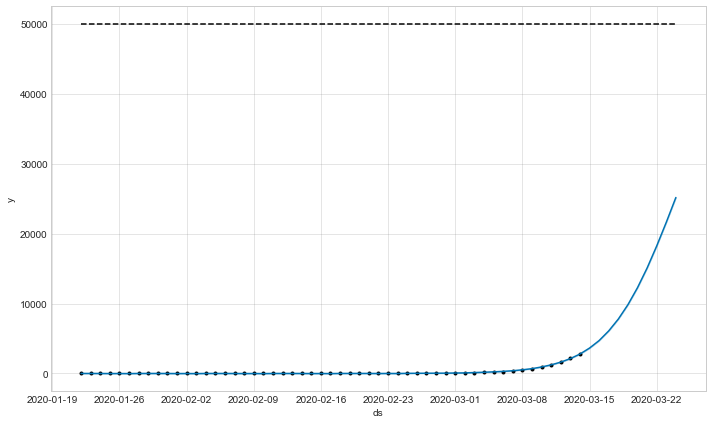

In [245]:
fig1 =m.plot(forecast)

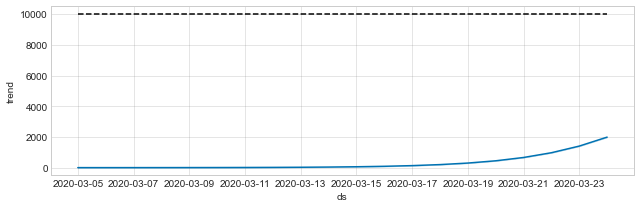

In [221]:
fig1 = m.plot_components(forecast)

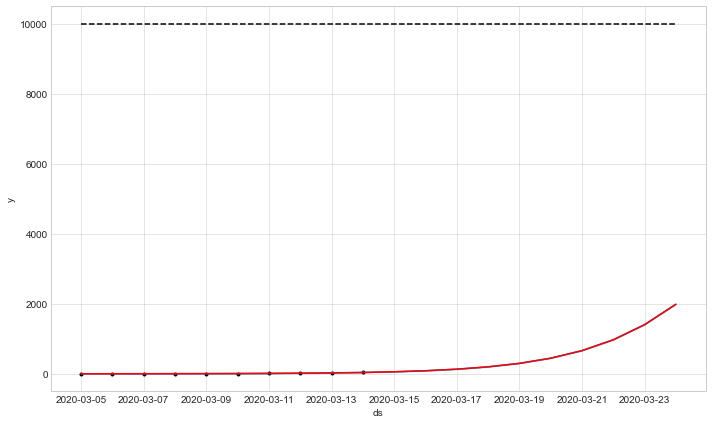

In [222]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [246]:
df_cv = cross_validation(m, period='1 days', horizon = '5 days')
df_cv.head()

INFO:fbprophet:Making 33 forecasts with cutoffs between 2020-02-06 00:00:00 and 2020-03-09 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-07,0.713706,-5.390533,6.366056,11,2020-02-06
1,2020-02-08,1.359303,-4.591391,7.514996,11,2020-02-06
2,2020-02-09,2.996571,-2.720018,8.754515,11,2020-02-06
3,2020-02-10,4.626224,-1.163211,10.074780,11,2020-02-06
4,2020-02-11,4.749036,-1.126344,10.901125,12,2020-02-06


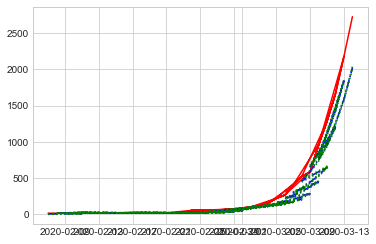

In [248]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
x = df_cv['ds']
ax.plot(x, df_cv['y'], color='red')
ax.plot(x, df_cv['yhat'], color='blue', linestyle='dashdot')
ax.plot(x, df_cv['yhat_lower'], color='green', linestyle='dotted')
ax.plot(x, df_cv['yhat_upper'], color='green', linestyle='dotted')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2020-01-22 to 2020-03-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       53 non-null     int64
dtypes: int64(1)
memory usage: 848.0 bytes
